<a href="https://colab.research.google.com/github/menguelx7/DiploDatos-AprendizajeProfundo/blob/master/4tp_aprendizajeNoSupervisado/4tp_aprendizajeNoSupervisado_grupo_2_Comentado_Mati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

isin# Selecci√≥n de cripto activos para una cartera de inversi√≥n

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Pr√°ctico 4 - Aprendizaje No Supervisado

# Introducci√≥n

En finanzas, encontrar grupos de activos similares o reg√≠menes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definici√≥n de reglas de compra/venta, etc. 

En este pr√°ctico aplicaremos m√©todos de aprendizaje no supervisado. Estas metodolog√≠as en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener informaci√≥n √∫til de nuestros datos.

Podemos destacar m√©todos como clustering y reducci√≥n de dimensionalidad. Algunas de las metodolog√≠as despliegan su m√°ximo potencial cuando se dispone de grandes cantidades de datos (activos en nuestro caso).

# üìñ ¬°Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas espec√≠ficas de tiempo. Nuestro objetivo ser√° encontrar activos con comportamiento similiar en t√©rmino de sus retornos.

Para esta actividad seleccionen periodos en los cuales est√© disponible la data de todos los activos. 

## Parte I 

Una forma sencilla de predecir el comportamiento de los activos ser√≠a suponer que todos siguen el mismo modelo de aprendizaje autom√°tico y crear este modelo global para predecir los rendimientos de todos los activos. Sin embargo, es posible que ellos reaccionen de manera diferente a un conjunto de indicadores t√©cnicos. Una forma de resolver este problema es crear un modelo diferente para grupos de activos que se espera que se comporten de manera similar.

Evaluen los siguientes algoritmos de clusterizaci√≥n. 

- Mean Shift.
- k-means. 
- Clustering Jer√°rquico 

¬øQu√© activos forman parte de cada cluster? ¬øEncuentran alguna relaci√≥n dentro de cada grupo?

## Parte II 

- Usar la medida de distancia dynamic time warping para agrupar por k-means y comparar con lo obtenido con la m√©trica eucl√≠dea ([link](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)). Comente los resultados.

## Opcional 

- Aplicar factores din√°micos para ver si las tasas de retorno se pueden resumir en uno o unos pocos constructos subyacentes ([link](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_dfm_coincident.html))

# Fecha de entrega

- __Versi√≥n preliminar: 12/9__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del an√°lisis desarrollado. El mismo debe estar pensado para un p√∫blico t√©cnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condici√≥n de que en el mismo se efect√∫e un an√°lisis escrito suficientemente detallado de los resultados. 

# Desarrollo

####Comenzaremos este entregable llamando a una base de datos que hemos trabajado previamente en informes anteriores. La misma comprende de los precios de apertura, cierre, m√°ximo y m√≠nimo de m√°s de una decena de criptomonedas. 

In [3]:
import pandas as pd
import numpy as np

import plotly.graph_objs as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

#clusters
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/diegoflorescba/MentoriaCripto2022-Grupo2/main/2tp_analisisYCuracion/Activos%20limpios%20con%20features%20-%202tp%20-%20Final.csv',index_col='Fecha')

####Armamos una funci√≥n "status" la cual utilizaremos m√°s adelante. A trav√©s de ella conoceremos informaci√≥n de la base de datos, como por ejemplo,valores nulos , cantidad de variables, informaci√≥n sobre las columnas de la misma, tipo de variables, entre otros. 

In [5]:
def status(data):

    data2=data 
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)

####De esta base de datos, armaremos uno nuevo, solo tomando aquellas columnas que consideramos de inter√©s. En este caso son:
* "profit" el cual es la diferencia entre el valor de un activo entre dos per√≠odos. Esto lo podemos interpretar como la ganancia o p√©rdida del valor monetario de este activo en dicho per√≠odo. 
* "close" es el valor de cierre de la criptomoneda al terminar un per√≠odo. Tomamos este valor y no otro ya que el close termina definiendo el valor real del activo al finalizar un per√≠odo, este indica si el valor subi√≥ o baj√≥ respecto al lapso anterior. 
* "active" es el conjunto de cripto activos que disponemos en la base de datos. 

In [6]:
columns_interesting = ['profit','close','active']
df_filter = df[columns_interesting]
df_filter

profit        close   active
Fecha                                              
2019-01-01 03:00:00  1.250000      0.35073  XRPUSDT
2019-01-01 03:00:00  2.019584    133.36000  ETHUSDT
2019-01-01 03:00:00  0.702214      2.53830  EOSUSDT
2019-01-01 03:00:00  1.830491      0.04061  ADAUSDT
2019-01-01 03:00:00  1.311806     30.12000  LTCUSDT
...                       ...          ...      ...
2022-05-02 11:00:00  2.492522     30.84000  AXSUSDT
2022-05-02 11:00:00  0.330984  38840.00000  BTCUSDT
2022-05-02 11:00:00  1.110575      2.09400  EOSUSDT
2022-05-02 11:00:00  1.507246     17.51000  NEOUSDT
2022-05-02 11:00:00  0.000000      0.77860  ADAUSDT

[116029 rows x 3 columns]

In [7]:
df_filter.index = pd.to_datetime(df_filter.index)
df_filter

profit        close   active
Fecha                                              
2019-01-01 03:00:00  1.250000      0.35073  XRPUSDT
2019-01-01 03:00:00  2.019584    133.36000  ETHUSDT
2019-01-01 03:00:00  0.702214      2.53830  EOSUSDT
2019-01-01 03:00:00  1.830491      0.04061  ADAUSDT
2019-01-01 03:00:00  1.311806     30.12000  LTCUSDT
...                       ...          ...      ...
2022-05-02 11:00:00  2.492522     30.84000  AXSUSDT
2022-05-02 11:00:00  0.330984  38840.00000  BTCUSDT
2022-05-02 11:00:00  1.110575      2.09400  EOSUSDT
2022-05-02 11:00:00  1.507246     17.51000  NEOUSDT
2022-05-02 11:00:00  0.000000      0.77860  ADAUSDT

[116029 rows x 3 columns]

#### Para poder explorar un poco mejor los cluster, agrupamos la recurrencia de cada activo. Actualmente tiene recurrencia de cada 4 horas, pas√°ndolo a diaria, sacando la media tanto del close como la del profit.

In [8]:
contador = 0
for i in set(df_filter.active):
    aux = df_filter[df_filter.active == i]
    aux2 = aux.resample("d").mean()
    aux2['active'] = i
    if contador == 0:
        df_filter_daily = aux2.copy()
        contador += 1
    else:
        df_filter_daily = pd.concat([df_filter_daily, aux2])
        # df_filter_daily = df_filter_daily.dropna()

####Validamos que dentro de esta base de datos no se encuentren valores nulos (NaN).

In [9]:
status(df_filter_daily)

variable  q_nan  p_nan  q_zeros  p_zeros  unique     type
0   profit      0    0.0        0      0.0   19392  float64
1    close      0    0.0        0      0.0   19132  float64
2   active      0    0.0        0      0.0      19   object

#### Una vez agrupado el set de datos por dia, se realiza el escalado por minimos y maximos por la columna close y profit, del 0 al 1 por cada activo. De esta manera podemos realizar cluster en base al rango y comportamiento de cada activo y no por el monto. Esto se debe a que el precio de los activos var√≠an significativamente, teniendo alg√∫nos cuyo valor unitario de es del orden de los centavos de d√≥lar, mientras que otros como el Bitcoin cotizan en decenas de miles de d√≥larees

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
contador = 0
for i in set(df_filter_daily.active):
    aux = df_filter_daily[df_filter_daily.active == i]
    aux[['Scalar_close']] = scaler.fit_transform(aux[["close"]])
    aux[['Scalar_profit']] = scaler.fit_transform(aux[["profit"]])
    if contador == 0:
        df_filter_daily_scalar = aux.copy()
        contador += 1
    else:
        df_filter_daily_scalar = pd.concat([df_filter_daily_scalar, aux])
        # df_filter_daily_scalar = df_filter_daily.dropna()

#### Validamos que no queden valores nulos (nan) luego del proceso.

In [11]:
status(df_filter_daily_scalar)

variable  q_nan  p_nan  q_zeros  p_zeros  unique     type
0         profit      0    0.0        0  0.00000   19392  float64
1          close      0    0.0        0  0.00000   19132  float64
2         active      0    0.0        0  0.00000      19   object
3   Scalar_close      0    0.0       19  0.00098   19264  float64
4  Scalar_profit      0    0.0       19  0.00098   19358  float64

#### Para poder evaluar de una manera mas visible se toma los 11 criptos con mayor volumen del mercado que analizamos en trabajos anteriores. Para ello, en el siguiente c√≥digo quitaremos los activos menos comercializados y solo nos quedaremos con los anteriormente mencionados.

In [12]:
criptos = list(['AAVEUSDT', 'AXSUSDT', 'BCHUSDT', 'COMPUSDT', 'DOTUSDT'])
df_filter_daily_scalar_top = df_filter_daily_scalar[~df_filter_daily_scalar.active.isin(criptos)]

In [13]:
df_filter_daily_scalar_top

profit        close   active  Scalar_close  Scalar_profit
Fecha                                                                  
2019-01-01  0.532013     0.352268  XRPUSDT      0.129595       0.540506
2019-01-02  0.286620     0.364292  XRPUSDT      0.136941       0.522281
2019-01-03 -0.503655     0.355893  XRPUSDT      0.131810       0.463587
2019-01-04  0.171644     0.351893  XRPUSDT      0.129366       0.513742
2019-01-05 -0.264973     0.352055  XRPUSDT      0.129465       0.481314
...              ...          ...      ...           ...            ...
2022-04-28  0.097963  2916.566667  ETHUSDT      0.602229       0.576542
2022-04-29 -0.495268  2850.498333  ETHUSDT      0.588083       0.532283
2022-04-30 -0.396176  2796.505000  ETHUSDT      0.576522       0.539676
2022-05-01  0.485397  2787.001667  ETHUSDT      0.574487       0.605447
2022-05-02 -0.123851  2830.600000  ETHUSDT      0.583822       0.559993

[16095 rows x 5 columns]

### Creamos un nuevo dataframe para dejar sin modificaciones el que ya agrupamos y escalamos.

In [14]:
# columns_interesting = ['Scalar_profit','profit','Scalar_close','close','active']
# df_pivot = df_filter_daily_scalar_top[columns_interesting]
df_pivot = df_filter_daily_scalar_top
df_pivot

profit        close   active  Scalar_close  Scalar_profit
Fecha                                                                  
2019-01-01  0.532013     0.352268  XRPUSDT      0.129595       0.540506
2019-01-02  0.286620     0.364292  XRPUSDT      0.136941       0.522281
2019-01-03 -0.503655     0.355893  XRPUSDT      0.131810       0.463587
2019-01-04  0.171644     0.351893  XRPUSDT      0.129366       0.513742
2019-01-05 -0.264973     0.352055  XRPUSDT      0.129465       0.481314
...              ...          ...      ...           ...            ...
2022-04-28  0.097963  2916.566667  ETHUSDT      0.602229       0.576542
2022-04-29 -0.495268  2850.498333  ETHUSDT      0.588083       0.532283
2022-04-30 -0.396176  2796.505000  ETHUSDT      0.576522       0.539676
2022-05-01  0.485397  2787.001667  ETHUSDT      0.574487       0.605447
2022-05-02 -0.123851  2830.600000  ETHUSDT      0.583822       0.559993

[16095 rows x 5 columns]

#### Tomamos de todas las columnas solo el nombre del activo y el close escalado, para posteriormente utilizarlo para las ejecuciones y validaciones de los cluster.

In [15]:
df_pivot = df_pivot[['active','Scalar_close']]
df_pivot

active  Scalar_close
Fecha                            
2019-01-01  XRPUSDT      0.129595
2019-01-02  XRPUSDT      0.136941
2019-01-03  XRPUSDT      0.131810
2019-01-04  XRPUSDT      0.129366
2019-01-05  XRPUSDT      0.129465
...             ...           ...
2022-04-28  ETHUSDT      0.602229
2022-04-29  ETHUSDT      0.588083
2022-04-30  ETHUSDT      0.576522
2022-05-01  ETHUSDT      0.574487
2022-05-02  ETHUSDT      0.583822

[16095 rows x 2 columns]

#### Realizamos el pivot de las columnas para que los diferentes activos sean clusterizados por el comportamiento

In [16]:
# df_kmeans = df_pivot[['active','Scalar_close']]
# df_kmeans = df_pivot
df_pivot = df_pivot.pivot(columns='active', values='Scalar_close')
df_pivot = df_pivot.reset_index()

#### Aplicamos la funci√≥n "status" anteriormente mencionada a la base de datos ya pivotada. 

In [17]:
status(df_pivot)

variable  q_nan     p_nan  q_zeros   p_zeros  unique            type
0      Fecha      0  0.000000        0  0.000000    1218  datetime64[ns]
1    ADAUSDT      0  0.000000        1  0.000821    1208         float64
2    BNBUSDT      0  0.000000        1  0.000821    1216         float64
3    BTCUSDT      0  0.000000        1  0.000821    1218         float64
4   DASHUSDT     86  0.070608        1  0.000821    1119         float64
5   DOGEUSDT    185  0.151888        1  0.000821    1027         float64
6    EOSUSDT      0  0.000000        1  0.000821    1212         float64
7    ETCUSDT      0  0.000000        1  0.000821    1216         float64
8    ETHUSDT      0  0.000000        1  0.000821    1216         float64
9   LINKUSDT     15  0.012315        1  0.000821    1196         float64
10   LTCUSDT      0  0.000000        1  0.000821    1207         float64
11  LUNAUSDT    598  0.490969        1  0.000821     616         float64
12   NEOUSDT      0  0.000000        1  0.000821    1214         float64
13   XMRUSDT     73  0.059934        1  0.000821    1138         float64
14   XRPUSDT      0  0.000000        1  0.000821    1215         float64

#### Eliminamos valores en nulos por la diferencias de fecha de creacion de las diferentes criptomonedas y eliminamos la fecha para que no entre en la evaluacion de los cluster

In [18]:
df_pivot = df_pivot.dropna()
# df_kmeans = df_kmeans.dropna()
df_pivot.drop('Fecha', axis='columns', inplace=True)

In [19]:
df_kmeams = df_pivot
df_kmeams

active   ADAUSDT   BNBUSDT   BTCUSDT  DASHUSDT  DOGEUSDT   EOSUSDT   ETCUSDT  \
598     0.034718  0.025430  0.129307  0.131997  0.002737  0.147109  0.026098   
599     0.033898  0.024850  0.128316  0.128325  0.002697  0.139951  0.025356   
600     0.032958  0.024498  0.128553  0.130803  0.002697  0.140684  0.025575   
601     0.033871  0.025449  0.130395  0.134528  0.002693  0.146032  0.026371   
602     0.031302  0.024522  0.125858  0.122954  0.002554  0.130170  0.024353   
...          ...       ...       ...       ...       ...       ...       ...   
1213    0.275676  0.600821  0.567032  0.148282  0.200322  0.042248  0.223259   
1214    0.266046  0.593493  0.554641  0.142204  0.198051  0.040335  0.212405   
1215    0.257196  0.583511  0.546482  0.132808  0.191675  0.028692  0.199211   
1216    0.253696  0.575728  0.543596  0.125868  0.190283  0.019060  0.190157   
1217    0.255584  0.580984  0.554350  0.129273  0.190234  0.021995  0.193987   

active   ETHUSDT  LINKUSDT   LTCUSDT  LUNAUSDT   NEOUSDT   XMRUSDT   XRPUSDT  
598     0.063377  0.281567  0.086879  0.001306  0.106089  0.143624  0.088649  
599     0.061600  0.302865  0.083824  0.001435  0.110103  0.134458  0.086554  
600     0.061326  0.293664  0.084497  0.001652  0.109279  0.130667  0.087432  
601     0.063884  0.297834  0.090173  0.001877  0.111013  0.134376  0.090078  
602     0.060872  0.285539  0.082859  0.001701  0.102571  0.127322  0.085236  
...          ...       ...       ...       ...       ...       ...       ...  
1213    0.602229  0.245493  0.207133  0.765416  0.115549  0.443837  0.308104  
1214    0.588083  0.236940  0.202235  0.738177  0.109420  0.429663  0.292798  
1215    0.576522  0.225446  0.197577  0.699113  0.104919  0.428584  0.287105  
1216    0.574487  0.215288  0.193447  0.693086  0.101664  0.406338  0.280578  
1217    0.583822  0.215790  0.200458  0.712503  0.103745  0.399976  0.291759  

[620 rows x 14 columns]

#### Transponemos todos los valores de las diferentes criptoactivos y se crea un array con cada valor de los diferentes criptos

In [20]:
df_kmeams = df_kmeams.T.values

In [21]:
df_kmeams

array([[0.03471822, 0.03389789, 0.03295843, ..., 0.25719635, 0.25369587,
        0.25558377],
       [0.0254304 , 0.02485043, 0.02449763, ..., 0.583511  , 0.57572782,
        0.58098399],
       [0.12930719, 0.12831631, 0.12855329, ..., 0.54648238, 0.54359564,
        0.55434966],
       ...,
       [0.10608851, 0.11010269, 0.10927891, ..., 0.10491936, 0.10166385,
        0.10374454],
       [0.14362403, 0.13445756, 0.13066673, ..., 0.42858418, 0.40633766,
        0.39997619],
       [0.08864923, 0.08655444, 0.08743228, ..., 0.28710538, 0.28057762,
        0.29175934]])

In [22]:
from yellowbrick.cluster import KElbowVisualizer

#### Validamos cual seria la cantidad de clusters optimos para este dataset, lo llevaremos a cabo a trav√©s de un m√©todo conocido como "m√©todo del codo" , donde vemos claramente que la distorsi√≥n comienza a decaer m√°s gradualmente a partir de los 4 clusters.

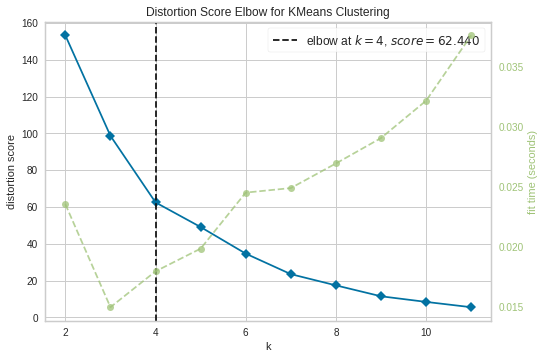

In [23]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_kmeams)
visualizer.show()
plt.show()

### Seg√∫n esta validacion podemos ver que con 4 clusters serian suficiente para validar el comportamiento de las diferentes criptos, por lo que una vez obtenido el valor optimo de clusters, se entrena el modelo.

### Para la clusterizaci√≥n utilizaremos KMeans como herramienta principal.

In [24]:
km_4 = KMeans(n_clusters=4,n_init=25, random_state=123)
km_4.fit(df_kmeams)

list_of_centers = km_4.cluster_centers_[:,1].tolist()

In [25]:
df_km_kmeans = pd.DataFrame(columns=df_pivot.columns, data=[km_4.labels_])
df_km_kmeans

active  ADAUSDT  BNBUSDT  BTCUSDT  DASHUSDT  DOGEUSDT  EOSUSDT  ETCUSDT  \
0             0        3        3         0         1        1        1   

active  ETHUSDT  LINKUSDT  LTCUSDT  LUNAUSDT  NEOUSDT  XMRUSDT  XRPUSDT  
0             3         0        0         2        1        0        0

#### Luego de realizar la clusterizaci√≥n, podemos saber a qu√© grupo pertenece cada cripto por igualdad de comportamiento. Ahora vamos agregar este grupo al dataset donde se encuentra todas las columnas, asi podremos graficar si son grupos con comportamientos similares.  

In [26]:
contador = 0
for i in df_km_kmeans.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_km_kmeans[i][0]
    if contador == 0:
        df_cluster_kmeans = aux.copy()
        contador += 1
    else:
        df_cluster_kmeans = pd.concat([df_cluster_kmeans, aux])

df_cluster_kmeans

profit     close   active  Scalar_close  Scalar_profit  cluster
Fecha                                                                        
2019-01-01  0.753079  0.040842  ADAUSDT      0.005710       0.677493        0
2019-01-02  0.720690  0.043108  ADAUSDT      0.006474       0.674966        0
2019-01-03 -0.434108  0.042657  ADAUSDT      0.006322       0.584853        0
2019-01-04  0.362739  0.042685  ADAUSDT      0.006331       0.647034        0
2019-01-05  0.873916  0.043920  ADAUSDT      0.006748       0.686923        0
...              ...       ...      ...           ...            ...      ...
2022-04-28 -0.304636  0.644417  XRPUSDT      0.308104       0.478368        0
2022-04-29 -0.525248  0.619367  XRPUSDT      0.292798       0.461983        0
2022-04-30 -0.841903  0.610050  XRPUSDT      0.287105       0.438465        0
2022-05-01  0.822043  0.599367  XRPUSDT      0.280578       0.562047        0
2022-05-02 -0.278358  0.617667  XRPUSDT      0.291759       0.480320        0

[16095 rows x 6 columns]

### Validamos rapidamente cual seria la distribucion de cada cluster

In [27]:
df_cluster_kmeans.cluster.value_counts()

0    7134
1    4687
3    3654
2     620
Name: cluster, dtype: int64

In [28]:
aux0 = df_cluster_kmeans[df_cluster_kmeans.cluster == 0]
aux1 = df_cluster_kmeans[df_cluster_kmeans.cluster == 1]
aux2 = df_cluster_kmeans[df_cluster_kmeans.cluster == 2]
aux3 = df_cluster_kmeans[df_cluster_kmeans.cluster == 3]

#### Graficamos todos los cluster para verificar el comportamiento de cada grupo. 

### En las gr√°ficas siguientes veremos que el precio de close escalado de las criptomonedas, en cada cluster, presentan patrones con algunas similitudes, donde se ven subidas y bajadas con pendientes similares en el mismo per√≠odo de tiempo. 
### Existe un caso particular, en el cluster 2 donde solo exite un √∫nico criptoactivo, que es LUNA, ya que este presenta un comportamiento opuesto al del resto de criptomonedas. 

In [29]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [30]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 1 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()

In [31]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 2 (Escalado) ' +active,
    width=1100,
    height=600,
    )

fig.show()

In [32]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_kmeans.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 3 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()


# Evaluamos ahora con la funci√≥n MeanShift

In [33]:
from sklearn.cluster import MeanShift, estimate_bandwidth
df_MeanShift = df_kmeams

In [34]:
bandwidth = estimate_bandwidth(df_MeanShift, quantile=0.2, n_samples=500)

In [35]:
ms = MeanShift(bandwidth=bandwidth)

ms.fit(df_MeanShift)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

y_pred  = ms.predict(df_MeanShift)

Cantidad de clusters encontrados por Mean Shift : 8


Text(0, 0.5, 'Feature 2')

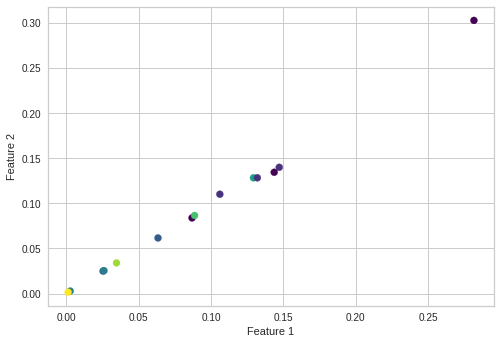

In [36]:
plt.scatter(df_MeanShift[:, 0], df_MeanShift[:, 1], c=y_pred, cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## Evaluamos distancia eucl√≠dea

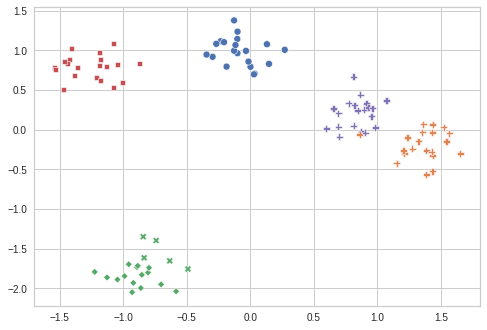

In [37]:
# Info en https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670
# Se modifica Data.

from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random

def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KMeans:
    def __init__(self, n_clusters=6, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, df_kmeams):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(df_kmeams)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, df_kmeams) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(df_kmeams)), size=1, p=dists)
            self.centroids += [df_kmeams[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in df_kmeams:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs
# Create a dataset of 2D distributions
centers = 5
df_kmeams, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42)
df_kmeams = StandardScaler().fit_transform(df_kmeams)
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.fit(df_kmeams)
# View results
class_centers, classification = kmeans.evaluate(df_kmeams)
sns.scatterplot(x=[X[0] for X in df_kmeams],
                y=[X[1] for X in df_kmeams],
                hue=true_labels,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in kmeans.centroids],
         [y for _, y in kmeans.centroids],
         'k+',
         markersize=10,
         )
plt.show()

# D.CLUSTERING JERARQUICO

In [38]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy as  shc

AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

AgglomerativeClustering()

In [39]:
df_pivot_Jerarq = df_pivot.reset_index()

In [40]:
df_pivot_Jerarq.drop('index', axis='columns', inplace=True)

In [41]:
df_pivot_Jerarq_trans = df_pivot_Jerarq
df_pivot_Jerarq_trans = df_pivot_Jerarq_trans.T
df_pivot_Jerarq_trans

0         1         2         3         4         5    \
active                                                                 
ADAUSDT   0.034718  0.033898  0.032958  0.033871  0.031302  0.030452   
BNBUSDT   0.025430  0.024850  0.024498  0.025449  0.024522  0.025072   
BTCUSDT   0.129307  0.128316  0.128553  0.130395  0.125858  0.125177   
DASHUSDT  0.131997  0.128325  0.130803  0.134528  0.122954  0.120144   
DOGEUSDT  0.002737  0.002697  0.002697  0.002693  0.002554  0.002516   
EOSUSDT   0.147109  0.139951  0.140684  0.146032  0.130170  0.120851   
ETCUSDT   0.026098  0.025356  0.025575  0.026371  0.024353  0.023424   
ETHUSDT   0.063377  0.061600  0.061326  0.063884  0.060872  0.060055   
LINKUSDT  0.281567  0.302865  0.293664  0.297834  0.285539  0.288352   
LTCUSDT   0.086879  0.083824  0.084497  0.090173  0.082859  0.078984   
LUNAUSDT  0.001306  0.001435  0.001652  0.001877  0.001701  0.001712   
NEOUSDT   0.106089  0.110103  0.109279  0.111013  0.102571  0.102914   
XMRUSDT   0.143624  0.134458  0.130667  0.134376  0.127322  0.124692   
XRPUSDT   0.088649  0.086554  0.087432  0.090078  0.085236  0.083482   

               6         7         8         9    ...       610       611  \
active                                            ...                       
ADAUSDT   0.028425  0.028711  0.030434  0.031017  ...  0.294061  0.290690   
BNBUSDT   0.025643  0.026035  0.026577  0.026869  ...  0.604738  0.599507   
BTCUSDT   0.123967  0.125986  0.126956  0.128635  ...  0.567360  0.566185   
DASHUSDT  0.114889  0.117467  0.119484  0.124450  ...  0.164532  0.157808   
DOGEUSDT  0.002421  0.002437  0.002513  0.002514  ...  0.195266  0.191651   
EOSUSDT   0.110951  0.118161  0.124456  0.130995  ...  0.054507  0.049724   
ETCUSDT   0.023379  0.023908  0.024190  0.024186  ...  0.254196  0.247524   
ETHUSDT   0.059761  0.061736  0.063607  0.066907  ...  0.609689  0.605360   
LINKUSDT  0.288041  0.293323  0.319997  0.331774  ...  0.262133  0.260095   
LTCUSDT   0.075022  0.076582  0.078114  0.086725  ...  0.217746  0.213184   
LUNAUSDT  0.001813  0.002237  0.002170  0.002179  ...  0.786268  0.778059   
NEOUSDT   0.102070  0.109067  0.128655  0.134506  ...  0.133540  0.128260   
XMRUSDT   0.124398  0.133010  0.136429  0.138695  ...  0.532711  0.499081   
XRPUSDT   0.077302  0.078816  0.081847  0.085388  ...  0.348982  0.342739   

               612       613       614       615       616       617  \
active                                                                 
ADAUSDT   0.284599  0.280615  0.274862  0.275676  0.266046  0.257196   
BNBUSDT   0.591850  0.587377  0.582930  0.600821  0.593493  0.583511   
BTCUSDT   0.564589  0.560274  0.556335  0.567032  0.554641  0.546482   
DASHUSDT  0.149791  0.148455  0.143885  0.148282  0.142204  0.132808   
DOGEUSDT  0.205599  0.215760  0.202814  0.200322  0.198051  0.191675   
EOSUSDT   0.043205  0.040546  0.036800  0.042248  0.040335  0.028692   
ETCUSDT   0.236264  0.230134  0.223137  0.223259  0.212405  0.199211   
ETHUSDT   0.601712  0.598743  0.592623  0.602229  0.588083  0.576522   
LINKUSDT  0.254314  0.249937  0.245159  0.245493  0.236940  0.225446   
LTCUSDT   0.207373  0.203868  0.200698  0.207133  0.202235  0.197577   
LUNAUSDT  0.796486  0.788607  0.765315  0.765416  0.738177  0.699113   
NEOUSDT   0.120503  0.119003  0.115224  0.115549  0.109420  0.104919   
XMRUSDT   0.482936  0.473226  0.437289  0.443837  0.429663  0.428584   
XRPUSDT   0.326649  0.318471  0.311200  0.308104  0.292798  0.287105   

               618       619  
active                        
ADAUSDT   0.253696  0.255584  
BNBUSDT   0.575728  0.580984  
BTCUSDT   0.543596  0.554350  
DASHUSDT  0.125868  0.129273  
DOGEUSDT  0.190283  0.190234  
EOSUSDT   0.019060  0.021995  
ETCUSDT   0.190157  0.193987  
ETHUSDT   0.574487  0.583822  
LINKUSDT  0.215288  0.215790  
LTCUSDT   0.193447  0.200458  
LUNAUSDT  0.693086  0.712503  
NEOUSDT   0.101664  0.103745  
XMRUSDT   0.406338  0.399976  
XRPUSDT   0

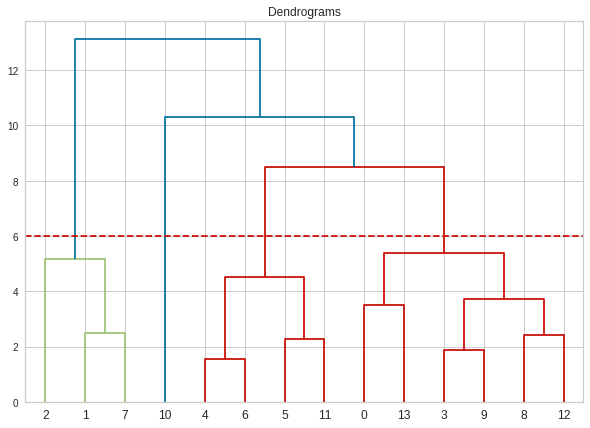

In [42]:
plt.figure(figsize=(10, 7))  

plt.title("Dendrograms")

z = shc.linkage(df_pivot_Jerarq_trans, method='ward')

dend = shc.dendrogram( z )

plt.axhline(y=6, color='r', linestyle='--')

plt.show()

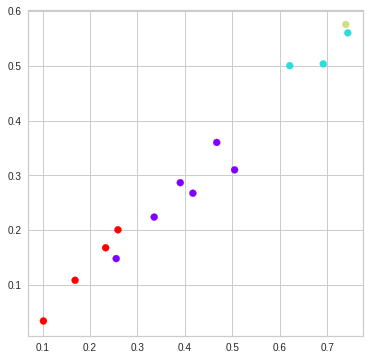

In [43]:
ac2 = AgglomerativeClustering(n_clusters = 4)

#Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(df_pivot_Jerarq_trans[513], df_pivot_Jerarq_trans[520],
          c = ac2.fit_predict(df_pivot_Jerarq_trans), cmap ='rainbow')
plt.show()

In [44]:
c = ac2.fit_predict(df_pivot_Jerarq_trans)
list_of_centers = ac2.labels_.tolist()

In [45]:
df_Jerarq = pd.DataFrame(columns=df_pivot.columns, data=[ac2.labels_])
df_Jerarq

active  ADAUSDT  BNBUSDT  BTCUSDT  DASHUSDT  DOGEUSDT  EOSUSDT  ETCUSDT  \
0             0        1        1         0         3        3        3   

active  ETHUSDT  LINKUSDT  LTCUSDT  LUNAUSDT  NEOUSDT  XMRUSDT  XRPUSDT  
0             1         0        0         2        3        0        0

In [46]:
contador = 0
for i in df_Jerarq.columns:
    aux = df_filter_daily_scalar_top[df_filter_daily_scalar_top.active == i]
    aux['cluster'] = df_Jerarq[i][0]
    if contador == 0:
        df_cluster_Jerarq = aux.copy()
        contador += 1
    else:
        df_cluster_Jerarq = pd.concat([df_cluster_Jerarq, aux])

df_cluster_Jerarq

profit     close   active  Scalar_close  Scalar_profit  cluster
Fecha                                                                        
2019-01-01  0.753079  0.040842  ADAUSDT      0.005710       0.677493        0
2019-01-02  0.720690  0.043108  ADAUSDT      0.006474       0.674966        0
2019-01-03 -0.434108  0.042657  ADAUSDT      0.006322       0.584853        0
2019-01-04  0.362739  0.042685  ADAUSDT      0.006331       0.647034        0
2019-01-05  0.873916  0.043920  ADAUSDT      0.006748       0.686923        0
...              ...       ...      ...           ...            ...      ...
2022-04-28 -0.304636  0.644417  XRPUSDT      0.308104       0.478368        0
2022-04-29 -0.525248  0.619367  XRPUSDT      0.292798       0.461983        0
2022-04-30 -0.841903  0.610050  XRPUSDT      0.287105       0.438465        0
2022-05-01  0.822043  0.599367  XRPUSDT      0.280578       0.562047        0
2022-05-02 -0.278358  0.617667  XRPUSDT      0.291759       0.480320        0

[16095 rows x 6 columns]

In [47]:
df_cluster_Jerarq.cluster.value_counts()

0    7134
3    4687
1    3654
2     620
Name: cluster, dtype: int64

In [48]:
aux0 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 0]
aux1 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 1]
aux2 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 2]
aux3 = df_cluster_Jerarq[df_cluster_Jerarq.cluster == 3]

In [49]:
fig = go.Figure()
for active in set(aux0.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [50]:
fig = go.Figure()
for active in set(aux1.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 0 (Escalado)',
    width=1100,
    height=600,
    )

fig.show()

In [51]:
fig = go.Figure()
for active in set(aux2.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 0 (Escalado) '+ active,
    width=1100,
    height=600,
    )

fig.show()

In [52]:
fig = go.Figure()
for active in set(aux3.active):
    aux=df_cluster_kmeans[df_cluster_Jerarq.active == active]['Scalar_close']
    fig.add_trace(go.Scatter(x=aux.index.astype(dtype=str), 
                            y=aux, name=active))

fig.update_layout(title='Evoluci√≥n de los precios en cluster 0 (Escalado) ',
    width=1100,
    height=600,
    )

fig.show()

# Conclusi√≥n

Como conclusi√≥n final, vemos que los clusters agrupan criptomonedas en base a multiples factores, pero viendo los gr√°ficos de cada cluster, podemos concluir que la tendencia de cada una de estas criptomonedas por cluster tienen cierta correlaci√≥n. A su vez, podemos ver que LUNA, que tiene un comportamiento distinto de las demas criptomonedas, est√° agrupada en un cluster separada del resto, por lo que es otro indicio de que estos clusters tuvieron una buena performance agrupando los activos. Por otro lado, si analizamos el cluster 3, vemos que se encuentran BTC, ETH y BNB, que son las 3 criptomonedas con m√°s capitalizaci√≥n de mercado y con un rendimiento similar una a otra.
A futuro, podriamos realizar algunos cluster utilizando otros features como indicadores t√©cnicos, para ver si podemos encontrar alguna otra relaci√≥n entre las cripto que a simple vista no se pueda ver.